## Введение
Данный эксперимент посвящен анализу производительности различных алгоритмов решения задачи достижимости между всеми парами вершин с контекстно-свободными ограничениями.

Исследуется производительность следующих алгоритмов:
1. Алгоритм Хеллингса. Грамматика должна находится в ОНФХ. Для каждого не терминала необходимо хранить из какой вершины
в какую можно "прийти". И на каждой итерации путем "склеивания" не терминалов проверяется есть ли такая продукция в грамматике, если да, то сохраняется не терминал с соответствующими вершинами, из которого выводится данная "склеенная" продукция.
2. Матричный алгоритм. Грамматика должна находится в ОНФХ. Строится матрица смежности графа и производится суммирование матрицы с ее квадратом, пока матрица изменяется.
3. Тензорный алгоритм. По КС грамматике строится рекурсивный автомат, для графа и автомата строятся матрицы смежности, далее пока результат изменяется, производиться пересечение матриц и транзитивное замыкание полученного пересечения, затем добавляем в граф ребра для вершин, для которых были найдены пути.

## Цель
Необходимо сравнить работу алгоритмов и ответить на поставленные вопросы:

- Какой из трёх указанных алгоритмов обладает лучшей производительностью?
- Имеет ли смысл для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для КС ограничений (ведь регулярные --- частный случай КС) или всё же лучше использовать специализированные алгоритмы для регулярных ограничений?

## Наборы данных
Выбор данных обусловлен тем, что хотелось рассмотреть поведение алгоритмов на графах различных размеров. На графах больших по числу узлов и ребер, чем [core](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/core.html#core), [gzip](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/gzip.html#gzip) и [lusearch](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/lusearch.html#lusearch) работа алгоритмов занимала слишком много времени. Работа алгоритмов проверяется на следующих графах:

#### Анализ RDF
1. [atom](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/atom.html#atom)
2. [pizza](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/pizza.html#pizza)
3. [core](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/core.html#core)

#### Анализ указателей в C
1. [wc](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/wc.html#wc)
2. [bzip](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/bzip.html#bzip)
3. [gzip](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/gzip.html#gzip)

#### Анализ Java-программ
1. [lusearch](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/lusearch.html#lusearch)

#### КС запросы
Запросы были взяты из классических грамматик для соответствующих групп графов в наборе:
- Для RDF графов:
  1. ```
      S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type
     ```
  2. ```
      S -> S -> subClassOf_r S subClassOf | subClassOf_r subClassOf
     ```
  3. ```
      S -> S -> type_r S type | type_r type
     ```

- Для графов языка C:
    ```
    S -> d_r V d
    V -> V1 V2 V3
    V1 -> epsilon
    V1 -> V2 a_r V1
    V2 -> epsilon
    V2 -> S
    V3 -> epsilon
    V3 -> a V2 V3
    ```

- Для графов языка JAVA:
    ```
    S -> PTh alloc
    PTh -> epsilon
    PTh -> assign PTh
    PTh -> load_0 Al store_0 PTh
    PTh -> load_1 Al store_1 PTh
    FT -> alloc_r FTh
    FTh -> epsilon
    FTh -> assign_r FTh
    FTh -> store_0_r Al load_0_r FTh
    FTh -> store_1_r Al load_1_r FTh
    Al -> S FT
    ```

#### Регулярные запросы
Для генерации регулярных выражений используются 4 самые распространенные метки на ребрах графа и строятся по следующему шаблону, где l1, l2, l3, l4 метки ребер:

   1.       (l1 | l2)* l3
   2.       (l3 | l4)+ l1*
   3.       l1 l2 l3 (l4|l1)*

## Описание эксперимента

#### Технические характеристики машины:
- Процессор: core i7-10750H 2.60GHz, 6 ядер, 12 логических процессоров.
- Кэш: 1ого уровня - 384 Кб, 2ого уровня 1,5 Мб, 3его уровня 12 Мб.
- Объем оперативной памяти: 16гб, 2933 МГц.
- ОС: Windows 10.
- Версия Python: 3.9.6

#### Проведение замеров:
Замеры времени производятся в секундах при помощи библиотеки [time](https://docs.python.org/3/library/time.html). Замеряется время работы функций из файла cfpq. На каждый вариант набора данных производится 10 запусков, вычисляется среднее арифметическое и стандартное отклонение значений времени и выводятся все замеры в виде диаграмм.



**Импортируем необходимые библиотеки и инициализируем глобальные переменные для эксперимента**


In [77]:
import time
from collections import Counter

import cfpq_data
from pyformlang.regular_expression import Regex
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from project.rpq import rpq_by_tensor

from project.cfpq import *

cfpq_data.logging.disable()

NUMBER_OF_LAUNCHES = 10
TYPE_OF_ALG_CFPQ = ["matrix", "tensor", "hellings"]
COMPARE_ALG_CFPQ_RPQ = ["matrix", "tensor", "tensor_rpq"]
RDF_DATASET_GRAPH = ["atom", "pizza", "core"]
C_DATASET_GRAPH = ["wc", "bzip", "gzip"]
JAVA_DATASET_GRAPH = ["lusearch"]

TYPE_OF_REGEXES = ["(l1 | l2)* l3",
                   "(l3 | l4)+ l1*",
                   "l1 l2 l3 (l4|l1)*"]

CFG_RDF = {
    "RDF S -> a S b | a b | x S y | x y": CFG.from_text(
        "S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type"
    ),
    "RDF S -> a S b | a b": CFG.from_text(
        "S -> subClassOf_r S subClassOf | subClassOf_r subClassOf"
    ),
    "RDF S -> x S y | x y": CFG.from_text(
        "S -> type_r S type | type_r type"
    ),
}

CFG_C = {
    "C_ALIAS": CFG.from_text(
        """
        S -> d_r V d
        V -> V1 V2 V3
        V1 -> epsilon
        V1 -> V2 a_r V1
        V2 -> epsilon
        V2 -> S
        V3 -> epsilon
        V3 -> a V2 V3
        """
    )
}


def cfgs_java(graph_name):
    cfg_path = cfpq_data.download_grammars("java_points_to", graph_name=graph_name)
    assert cfg_path is not None
    cfg_path = cfg_path / f"java_points_to_{graph_name}.txt"
    assert cfg_path.exists()
    return {"JAVA_POINTS_TO": cfpq_data.cfg_from_txt(cfg_path)}

**Функция для отрисовки диаграммы**

In [78]:
def draw_diagram(graphs, algos_time, algos_deviation, type_algos, type_of_graphs="", query=""):
    index = np.arange(len(graphs))
    bw = 0.2
    plt.title(type_of_graphs + " " + query, fontsize=12)
    colors = ["r", "b", "g", "y"]
    for count, name_algos in enumerate(type_algos):
        plt.bar(index + bw * (count + 1), algos_time[name_algos], bw,
                yerr=algos_deviation[name_algos],
                error_kw={'ecolor': '0.1', 'capsize': 6}, alpha=0.7, color=colors[count], label=name_algos)
    plt.xlabel('Graphs')
    plt.ylabel('Time, seconds')
    plt.xticks(index + 1 * bw, graphs)
    plt.yscale('log')
    plt.legend(loc=1)
    plt.show()

**Функция для генерации регулярных выражений по графу**

In [79]:
def generate_regexes(graph, num_of_type):
    most_common_labels = Counter(list(map(lambda node: node[2]["label"], graph.edges.data()))).most_common(4)
    if num_of_type == 0:
        return "(" + str(most_common_labels[0][0]) + "|" + str(most_common_labels[1][0]) + ")*" + str(
            most_common_labels[2][0])
    elif num_of_type == 1:
        return "(" + str(most_common_labels[2][0]) + "|" + str(most_common_labels[3][0]) + ")|(" + str(
            most_common_labels[2][0]) + "|" + str(most_common_labels[3][0]) + ")*" + str(
            most_common_labels[0][0]) + "*"
    else:
        return str(most_common_labels[0][0]) + " " + str(most_common_labels[1][0]) + " " + str(
            most_common_labels[2][0]) + "(" + str(most_common_labels[3][0]) + "|" + str(
            most_common_labels[0][0]) + ")*"

### Рассмотрим работу алгоритмов с КС ограничениями
**Функция запуска алгоритмов по КС грамматикам**

In [80]:
def pq_by_cfg(cfgs, graphs):
    for type_of_graphs, cfg in cfgs.items():
        algos_time = {"hellings": [], "matrix": [], "tensor": []}
        algos_deviation = {"hellings": [], "matrix": [], "tensor": []}
        for graph_name in graphs:
            graph = cfpq_data.graph_from_csv(cfpq_data.download(graph_name))
            graph2 = cfpq_data.add_reverse_edges(graph)
            for alg_name in TYPE_OF_ALG_CFPQ:
                times = []
                if alg_name == "hellings" and (
                        graph_name == "gzip" or graph_name == "lusearch"):
                    algos_time[alg_name].append(0)
                    algos_deviation[alg_name].append(0)
                    continue
                if alg_name == "tensor" and graph_name == "lusearch":
                    algos_time[alg_name].append(0)
                    algos_deviation[alg_name].append(0)
                    continue
                for i in range(NUMBER_OF_LAUNCHES):
                    start_time = time.time()
                    cfpq(graph=graph2, cfg=cfg, alg_type=alg_name)
                    final_time = time.time() - start_time
                    times.append(final_time)
                mean_time = np.mean(times)
                deviation = stats.tstd(times)
                algos_time[alg_name].append(mean_time)
                algos_deviation[alg_name].append(deviation)
        draw_diagram(graphs, algos_time, algos_deviation, TYPE_OF_ALG_CFPQ, type_of_graphs=type_of_graphs)

**Диаграммы производительности алгоритмов для RDF графов**

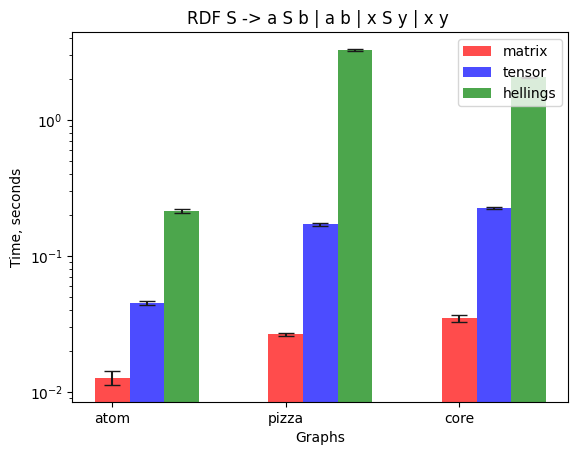

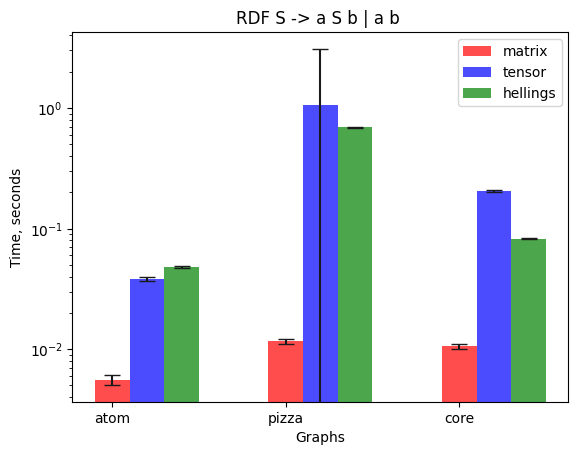

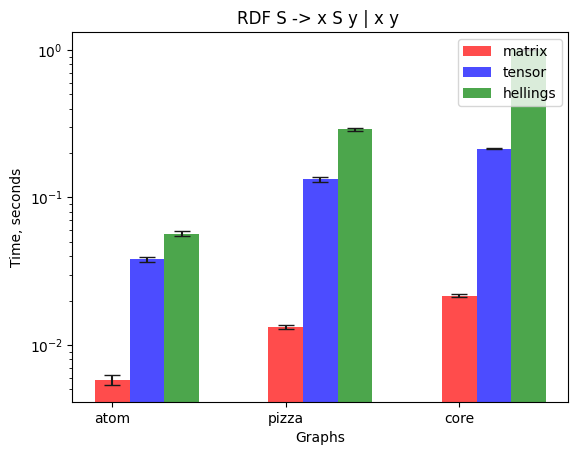

In [81]:
pq_by_cfg(CFG_RDF, RDF_DATASET_GRAPH)

**Диаграмма производительности алгоритмов для графов языка C**
На графе [gzip](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/gzip.html#gzip) алгоритм Хеллингса не запускался, так как его работа занимала слишком много времени.

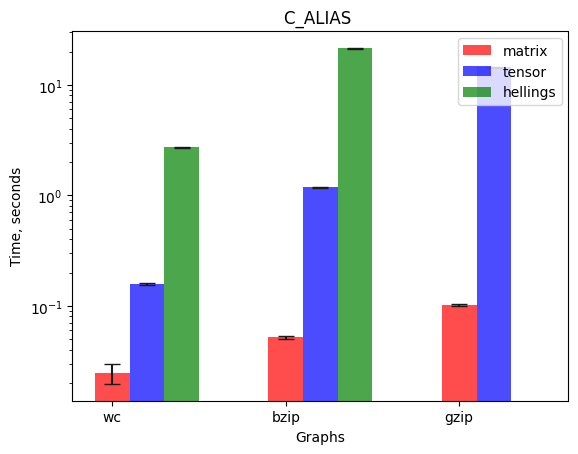

In [82]:
pq_by_cfg(CFG_C, C_DATASET_GRAPH)

**Диаграмма производительности алгоритмов для графа языка JAVA**
Алгоритмы Хеллингса и тензорный не запускались, так как их работа занимала слишком много времени.

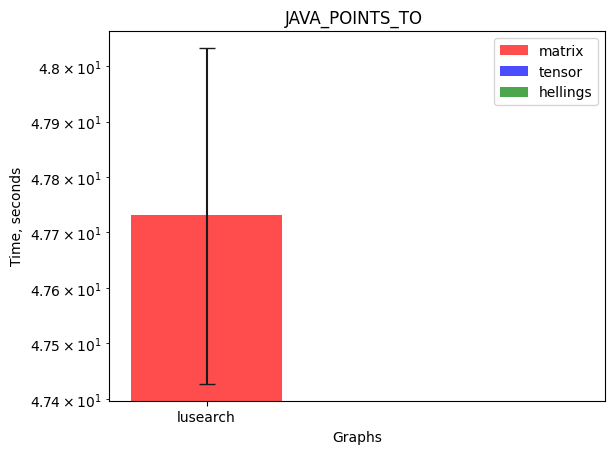

In [83]:
CFG_JAVA = {}
for java_graphs in JAVA_DATASET_GRAPH:
    CFG_JAVA = cfgs_java(java_graphs)
pq_by_cfg(CFG_JAVA, JAVA_DATASET_GRAPH)

**Вывод по вопросу 1 (какой из алгоритмов обладает наилучшей производительностью?):**
На всех наборах данных матричный алгоритм отрабатывает быстрее алгоритмов Хеллингса и тензорного, далее следует тензорный алгоритм, а алгоритм Хеллингса оказался самым медленным.

### Рассмотрим работу алгоритмов с регулярными ограничениями
Алгоритм Хеллингса в данных экспериментах не запускался, так как по предыдущему пункту выяснилось, что он отрабатывает дольше по сравнению с другими алгоритмами. Для сравнения производительности алгоритмов с регулярными ограничениями возьмем специализированный тензорный алгоритм для регулярных запросов, по опытам из [прошлой работы](https://github.com/danielsheh02/formal-lang-course/blob/task5/exp.ipynb) он являлся наиболее производительным.


**Функция запуска алгоритмов по регулярным выражениям**:

In [84]:
def pq_by_regex(graphs, type_of_graphs):
    for num_of_type, regex in enumerate(TYPE_OF_REGEXES):
        algos_time = {"hellings": [], "matrix": [], "tensor": [], "tensor_rpq": []}
        algos_deviation = {"hellings": [], "matrix": [], "tensor": [], "tensor_rpq": []}
        for graph_name in graphs:
            graph = cfpq_data.graph_from_csv(cfpq_data.download(graph_name))
            graph2 = cfpq_data.add_reverse_edges(graph)
            query = Regex(generate_regexes(graph2, num_of_type))
            for alg_name in COMPARE_ALG_CFPQ_RPQ:
                times = []
                for i in range(NUMBER_OF_LAUNCHES):
                    if alg_name == "tensor_rpq":
                        start_time = time.time()
                        rpq_by_tensor(graph2, query)
                        final_time = time.time() - start_time
                        times.append(final_time)
                    else:
                        cfg = query.to_cfg()
                        start_time = time.time()
                        cfpq(graph=graph2, cfg=cfg, alg_type=alg_name)
                        final_time = time.time() - start_time
                        times.append(final_time)
                mean_time = np.mean(times)
                deviation = stats.tstd(times)
                algos_time[alg_name].append(mean_time)
                algos_deviation[alg_name].append(deviation)
        draw_diagram(graphs, algos_time, algos_deviation, COMPARE_ALG_CFPQ_RPQ, type_of_graphs=type_of_graphs,
                     query=regex)

**Диаграммы производительности алгоритмов для RDF графов**

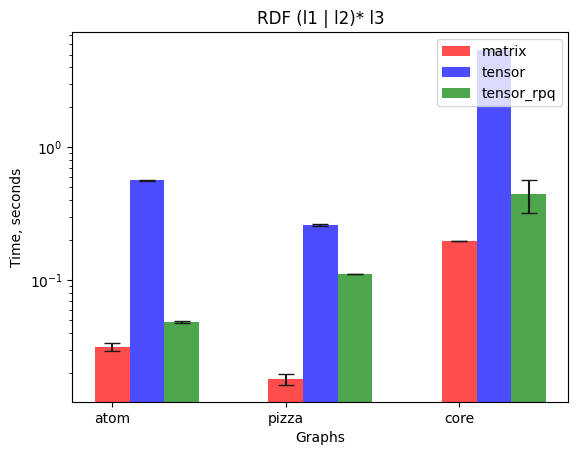

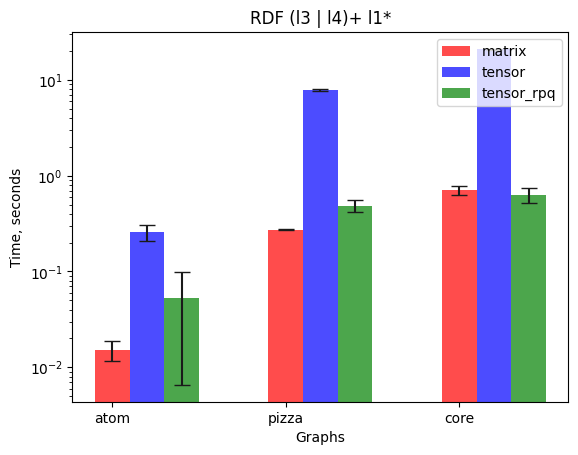

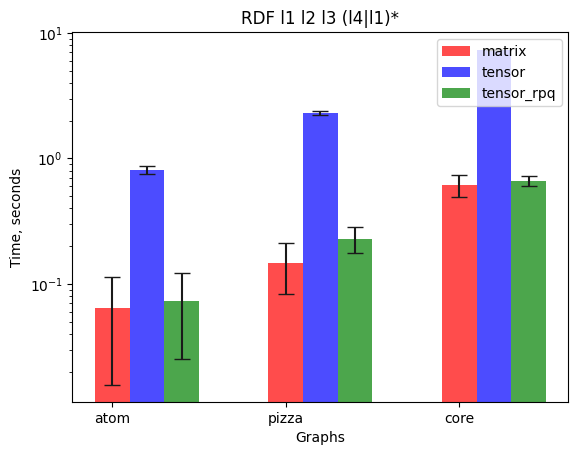

In [85]:
pq_by_regex(RDF_DATASET_GRAPH, "RDF")

**Диаграмма производительности алгоритмов для графов языка C**

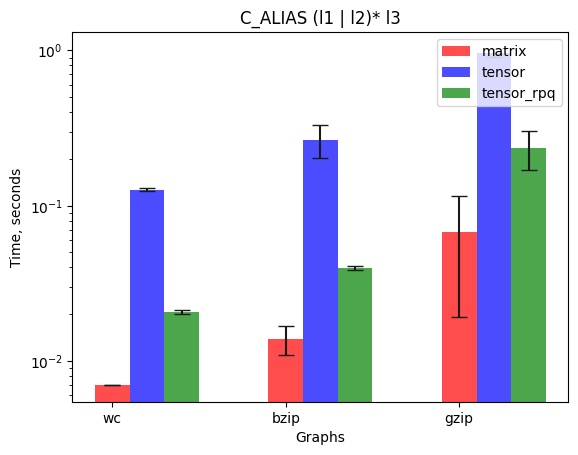

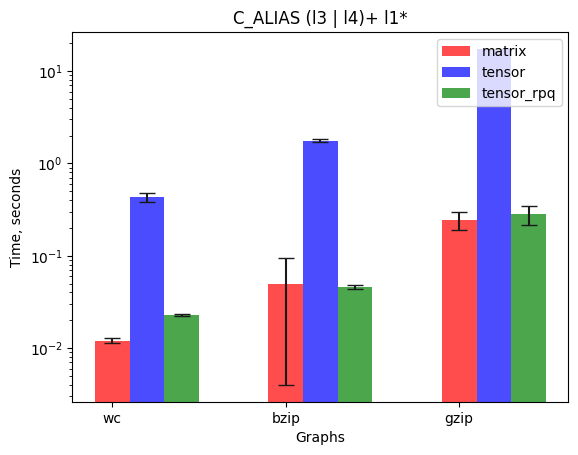

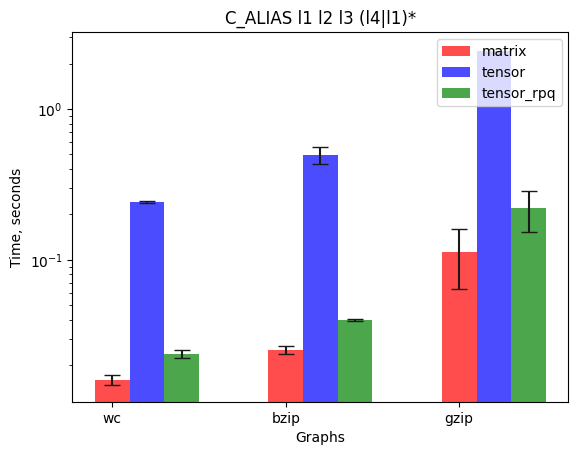

In [86]:
pq_by_regex(C_DATASET_GRAPH, "C_ALIAS")

**Диаграмма производительности алгоритмов для графа языка JAVA**

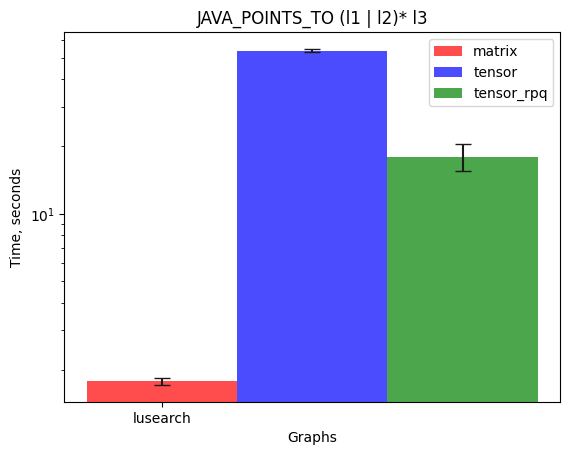

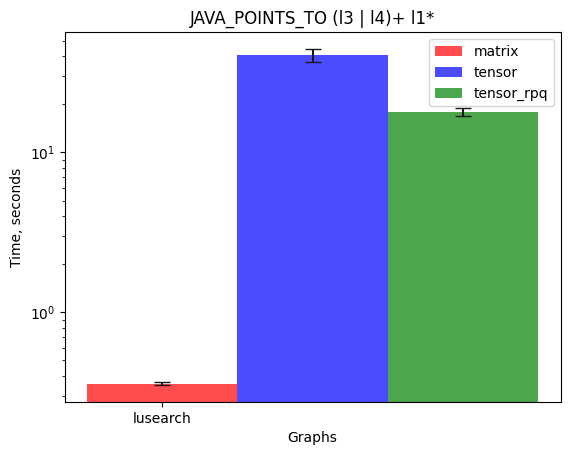

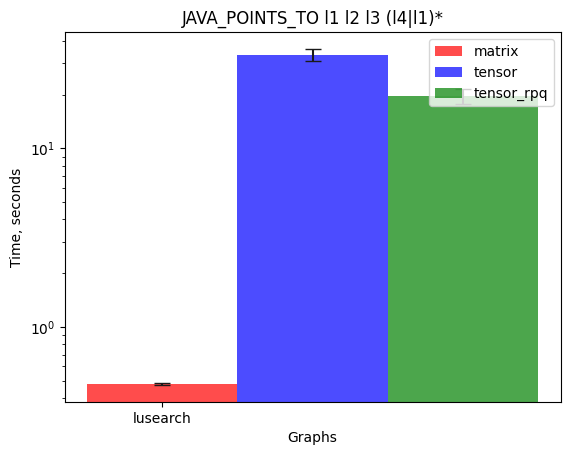

In [87]:
pq_by_regex(JAVA_DATASET_GRAPH, "JAVA_POINTS_TO")

**Вывод по вопросу 2 (имеет ли смысл для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для КС ограничений?):**
Да, имеет смысл, так как на всех наборах данных матричный алгоритм для КС отрабатывает быстрее остальных. Но тензорный алгоритм, специализированный для регулярных ограничений, оказывается быстрее тензорного для КС.

#### Заключение
В ходе экспериментов по исследованию производительности алгоритмов для решения задачи достижимости с контекстно-свободными ограничениями были получены следующие результаты:
1. Наиболее эффективным в плане скорости работы является матричный алгоритм.
2. Для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для КС ограничений имеет смысл. Как показали результаты эксперимента матричный алгоритм для КС оказался быстрее тензорного алгоритма для регулярных ограничений.